In [1]:
%matplotlib inline
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.datasets import ad_hoc_data, breast_cancer

from classifiers.quantum.qasvm import NormQSVM, PseudoNormQSVM
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from classifiers.visualization import Plot_SVM
from classifiers.quantum.ansatz import Circuit3, PQC_Properties

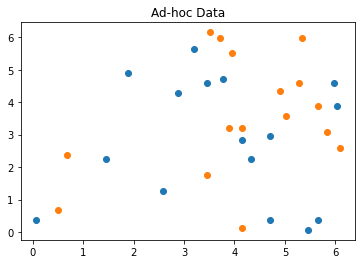

In [4]:
reps = 3
dim = 2
X, y, Xt, yt, total = ad_hoc_data(
    training_size=2**4,
    test_size=2**4,
    n=dim,
    plot_data=True,
    one_hot=False,
    gap=0.3,
    include_sample_total=True
)

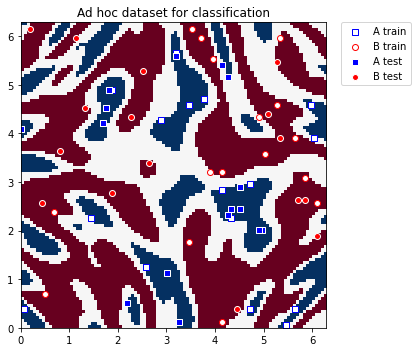

In [13]:
plt.figure(figsize=(6, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(total).T, interpolation='nearest',origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(X[np.where(y[:] == 0), 0], X[np.where(y[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='b', label="A train")
plt.scatter(X[np.where(y[:] == 1), 0], X[np.where(y[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r', label="B train")
plt.scatter(Xt[np.where(yt[:] == 0), 0], Xt[np.where(yt[:] == 0), 1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(Xt[np.where(yt[:] == 1), 0], Xt[np.where(yt[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")

plt.tight_layout()
plt.savefig(f'./figs/orinal(reps={reps})')

In [6]:
feature_map =  ZZFeatureMap(feature_dimension=dim, reps=2, entanglement='linear')
var_form = Circuit3(5, reps=reps)
backend = QuantumInstance(AerSimulator(), shots=2**13, seed_simulator=None)
nqsvm = NormQSVM(X, y, quantum_instance=backend, lamda=1, feature_map=feature_map, var_form=var_form)
storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**10, blocking=True, callback=storage, last_avg=16)
expr = PQC_Properties(var_form).expressibility()

In [7]:
from tqdm.notebook import tqdm
last_avg = 16
epochs = 2**9
for epoch in tqdm(range(epochs)):
    optimizer.step(nqsvm.cost_fn, nqsvm.parameters)

  0%|          | 0/512 [00:00<?, ?it/s]

In [8]:
nqsvm.parameters = storage.last_avg(last_avg, True)

(0.0, 0.3)

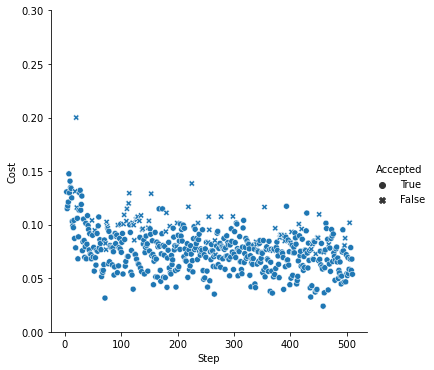

In [9]:
storage.plot()
plt.ylim([0, 0.3])

In [10]:
storage.num_accepted()

440

In [11]:
nqsvm.accuracy(Xt, yt)

0.96875

In [12]:
nqsvm.save('./tmp/nqsvm')
Xtot = np.concatenate([X, Xt])
ytot = np.concatenate([y, yt])
np.save('./tmp/Xtot.npy', Xtot)
np.save('./tmp/ytot.npy', ytot)
# esty = nqsvm.predict(Xtot)
raise Exception

Exception: 

# Run 'analy_nqsvm.py' fisrt

<ipython-input-14-d56e8e417319>:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(Xtot[np.where(esty!=ytot), 0], Xtot[np.where(esty!=ytot), 1],


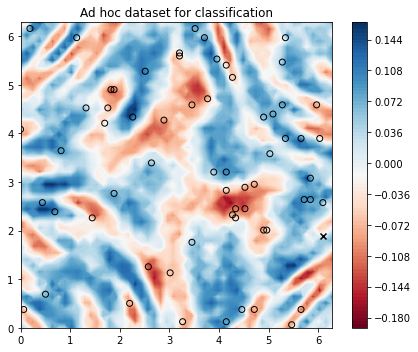

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dill

with open('./tmp/nqsvm', 'rb') as f:
    nqsvm = dill.load(f)
Xtot = np.load('./tmp/Xtot.npy')
ytot = np.load('./tmp/ytot.npy')
XX, YY, ZZ = np.load('./tmp/XYZ.npy')
esty = np.load('./tmp/esty.npy')

plt.figure(figsize=(6, 5))
plt.contourf(XX, YY, ZZ, levels=100, cmap='RdBu')
plt.colorbar()
# plt.scatter(X[np.where(y[:] == 0), 0], X[np.where(y[:] == 0), 1],
            # marker='s', facecolors='w', edgecolors='b', label="A train")
# plt.scatter(X[np.where(y[:] == 1), 0], X[np.where(y[:] == 1), 1],
            # marker='o', facecolors='w', edgecolors='r', label="B train")
# plt.scatter(Xt[np.where(yt[:] == 0), 0], Xt[np.where(yt[:] == 0), 1],
            # marker='s', facecolors='b', edgecolors='w', label="A test")
# plt.scatter(Xt[np.where(yt[:] == 1), 0], Xt[np.where(yt[:] == 1), 1],
            # marker='o', facecolors='r', edgecolors='w', label="B test")
plt.scatter(Xtot[np.where(esty==ytot), 0], Xtot[np.where(esty==ytot), 1],
            marker='o', facecolors='none', edgecolors='k', label="Correct")
plt.scatter(Xtot[np.where(esty!=ytot), 0], Xtot[np.where(esty!=ytot), 1],
            marker='x', facecolors='k', edgecolors='k', label="Wrong")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")
plt.tight_layout()
plt.savefig(f'./figs/result(reps={reps}, acc={sum(esty==ytot)/len(esty)}, expr={expr}).png')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table


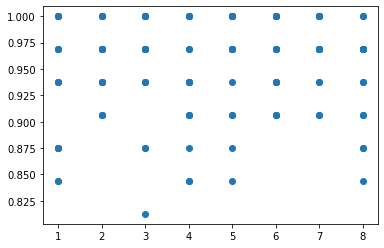

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

x, y, z = np.load('./tmp/Ciruit3/result.npy')
plt.scatter(x, z)

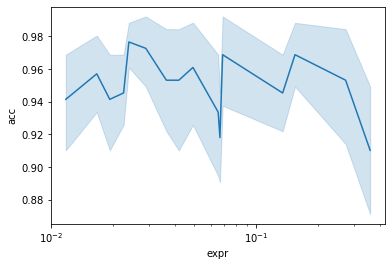

In [18]:
d = DataFrame(data=np.load('./tmp/Ciruit3/result.npy').T, columns=['layer', 'expr', 'acc'])
sns.lineplot(data=d, x='expr', y='acc')
plt.xscale('log')

matplotlib.figure.Figure

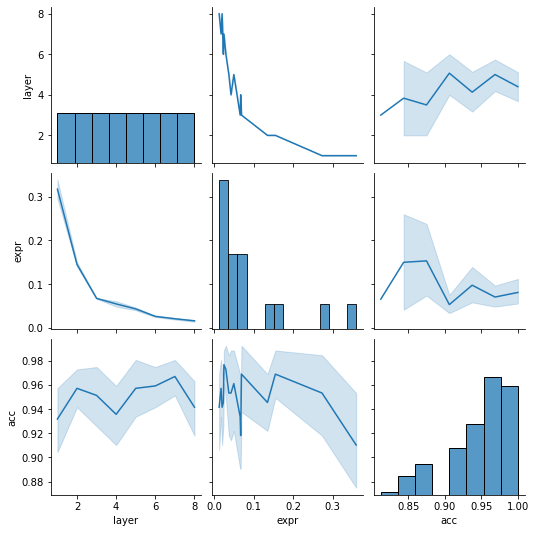

In [29]:
g = sns.PairGrid(data=d)
g.map_diag(sns.histplot)
g.map_offdiag(sns.lineplot)
g.tight_layout()
type(g.fig)

In [72]:
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from itertools import permutations
n=4
L=1
pv = ParameterVector('θ', (n**2+3*n)*L)
param_list = []
qc = TwoLocal(4, rotation_blocks=None, reps=0, entanglement_blocks=None, entanglement=None)
qc1 = TwoLocal(4, rotation_blocks=['rx', 'rz'], reps=1, entanglement_blocks=None, entanglement=None,
              skip_final_rotation_layer=True, insert_barriers=True, parameter_prefix='_tmp1')
list(map(param_list.append, qc1.parameters))
qc2 = QuantumCircuit(n, name='ent')
for i, j in permutations(range(n), 2):
    p = Parameter(f"_ent_{i}_{j}")
    qc2.crz(p, i, j)
    param_list.append(p)
qc2.barrier()
qc3 = TwoLocal(4, rotation_blocks=['rx', 'rz'], reps=1, entanglement_blocks=None, entanglement=None,
              skip_final_rotation_layer=True, insert_barriers=True, parameter_prefix='_tmp2')
list(map(param_list.append, qc3.parameters))
qc.compose(qc1, inplace=True)
qc.compose(qc2, inplace=True, wrap=True)
qc.compose(qc3, inplace=True)
qc.assign_parameters(dict(zip(param_list, pv)), inplace=True)
print(qc.decompose().draw(fold=120))



     ┌───────────┐┌──────────┐┌──────────┐ ░                                      ┌───────────┐             »
q_0: ┤0          ├┤ Rx(θ[0]) ├┤ Rz(θ[4]) ├─░──────■───────────■────────────■──────┤ Rz(θ[11]) ├─────────────»
     │           │├──────────┤├──────────┤ ░ ┌────┴─────┐     │            │      └─────┬─────┘             »
q_1: ┤1          ├┤ Rx(θ[1]) ├┤ Rz(θ[5]) ├─░─┤ Rz(θ[8]) ├─────┼────────────┼────────────■────────────■──────»
     │  TwoLocal │├──────────┤├──────────┤ ░ └──────────┘┌────┴─────┐      │                   ┌─────┴─────┐»
q_2: ┤2          ├┤ Rx(θ[2]) ├┤ Rz(θ[6]) ├─░─────────────┤ Rz(θ[9]) ├──────┼───────────────────┤ Rz(θ[12]) ├»
     │           │├──────────┤├──────────┤ ░             └──────────┘┌─────┴─────┐             └───────────┘»
q_3: ┤3          ├┤ Rx(θ[3]) ├┤ Rz(θ[7]) ├─░─────────────────────────┤ Rz(θ[10]) ├──────────────────────────»
     └───────────┘└──────────┘└──────────┘ ░                         └───────────┘                          »
«         

In [75]:
list(pv)

[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3]),
 ParameterVectorElement(θ[4]),
 ParameterVectorElement(θ[5]),
 ParameterVectorElement(θ[6]),
 ParameterVectorElement(θ[7]),
 ParameterVectorElement(θ[8]),
 ParameterVectorElement(θ[9]),
 ParameterVectorElement(θ[10]),
 ParameterVectorElement(θ[11]),
 ParameterVectorElement(θ[12]),
 ParameterVectorElement(θ[13]),
 ParameterVectorElement(θ[14]),
 ParameterVectorElement(θ[15]),
 ParameterVectorElement(θ[16]),
 ParameterVectorElement(θ[17]),
 ParameterVectorElement(θ[18]),
 ParameterVectorElement(θ[19]),
 ParameterVectorElement(θ[20]),
 ParameterVectorElement(θ[21]),
 ParameterVectorElement(θ[22]),
 ParameterVectorElement(θ[23]),
 ParameterVectorElement(θ[24]),
 ParameterVectorElement(θ[25]),
 ParameterVectorElement(θ[26]),
 ParameterVectorElement(θ[27])]

In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects/'])

In [3]:
from classifiers.quantum.ansatz import sample_circuit

qc = sample_circuit(circuit_id=1)(num_qubits=4, reps=1)
qc.decompose().draw()


┌──────────┐┌──────────┐
q_0: ┤ Rx(θ[0]) ├┤ Rz(θ[4]) ├
     ├──────────┤├──────────┤
q_1: ┤ Rx(θ[1]) ├┤ Rz(θ[5]) ├
     ├──────────┤├──────────┤
q_2: ┤ Rx(θ[2]) ├┤ Rz(θ[6]) ├
     ├──────────┤├──────────┤
q_3: ┤ Rx(θ[3]) ├┤ Rz(θ[7]) ├
     └──────────┘└──────────┘